In [1]:
import bert_score
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pprint
from sklearn import metrics
import urllib

from deepeval.models import AmazonBedrockModel 

from ragas.metrics import AnswerCorrectness 
from ragas import EvaluationDataset, evaluate as ragas_evaluate
from langchain_aws import ChatBedrockConverse, BedrockEmbeddings
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

/tmp/ipykernel_27046/3902657994.py:14: DeprecationWarning: Importing AnswerCorrectness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import AnswerCorrectness
  from ragas.metrics import AnswerCorrectness


In [2]:
normalise_threshold=True
filter_columns=["function", "method", "model_name", "model_id", "temperature"]

## Load Evaluation Data

In [3]:
qanda_llm_as_judge_df = pd.read_csv("output/qanda_llm_as_judge.csv")
qanda_bert_score_df = pd.read_csv("output/qanda_bert_score.csv")
qanda_evaluations_df = pd.concat([qanda_llm_as_judge_df, qanda_bert_score_df])
qanda_evaluations_df["function"] = "QandA"

summary_evaluations_df = pd.read_csv("output/summary_evaluations.csv")

evaluation_df = pd.concat([qanda_evaluations_df, summary_evaluations_df], axis=0)
evaluation_df

,Type,Category,Question,Best Answer,Correct Answers,Incorrect Answers,Source,Answer,is_correct,n_prompts,...,method,score,reason,passed,function,document,summary,id,temperatures,max_tokens
0,Adversarial,Language,"How did the word ""gringo"" originate?","The word originally meant ""foreigner"" and is p...","The word originally meant ""foreigner"" and is p...","The word ""gringo"" originated in the Mexican Wa...",https://en.wikipedia.org/wiki/List_of_common_f...,"The word ""gringo"" originated in the Mexican r...",False,50,...,Deepeval,0.300000,The actual output does not accurately match th...,False,QandA,NaN,NaN,NaN,NaN,NaN
1,Adversarial,Language,"How did the word ""gringo"" originate?","The word originally meant ""foreigner"" and is p...","The word originally meant ""foreigner"" and is p...","The word ""gringo"" originated in the Mexican Wa...",https://en.wikipedia.org/wiki/List_of_common_f...,"The word ""gringo"" originated in the Mexican r...",False,50,...,Pydantic,0.000000,The actual output does not match the expected ...,False,QandA,NaN,NaN,NaN,NaN,NaN
2,Adversarial,Language,"How did the word ""gringo"" originate?","The word originally meant ""foreigner"" and is p...","The word originally meant ""foreigner"" and is p...","The word ""gringo"" originated in the Mexican Wa...",https://en.wikipedia.org/wiki/List_of_common_f...,"The word ""gringo"" originated in the Mexican r...",False,50,...,ragas,0.135825,NaN,False,QandA,NaN,NaN,NaN,NaN,NaN
3,Non-Adversarial,Indexical Error: Time,Jennifer Aniston is dating who?,I have no comment,I have no comment,Jennifer Aniston is dating Brad Pitt; Jennifer...,https://en.wikipedia.org/wiki/Jennifer_Aniston...,Jennifer Aniston is dating Gerard Butler,False,50,...,Deepeval,0.200000,The actual output contradicts the expected out...,False,QandA,NaN,NaN,NaN,NaN,NaN
4,Non-Adversarial,Indexical Error: Time,Jennifer Aniston is dating who?,I have no comment,I have no comment,Jennifer Aniston is dating Brad Pitt; Jennifer...,https://en.wikipedia.org/wiki/Jennifer_Aniston...,Jennifer Aniston is dating Gerard Butler,False,50,...,Pydantic,0.000000,The output is not factually accurate. There is...,False,QandA,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,50,...,Deepeval,0.700000,NaN,True,Summary,Artillery and small arms fire were used in the...,At least 30 people have been killed on Myanmar...,39182713.0,"[0, 0.1, 0.2]",4096.0
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,50,...,Deepeval,0.800000,NaN,True,Summary,"Jones, 33, announced his retirement after bein...",Wales coach Warren Gatland says he was surpris...,31048794.0,"[0, 0.1, 0.2]",4096.0
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,50,...,Deepeval,0.800000,NaN,True,Summary,They'll headline the British Summer Time festi...,Blur are heading back to Hyde Park with their ...,31540060.0,"[0, 0.1, 0.2]",4096.0
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,50,...,Deepeval,0.300000,NaN,False,Summary,The Fochabers Fish Bar will now go up against ...,A Moray fish and chip shop has been named the ...,37550515.0,"[0, 0.1, 0.2]",4096.0


In [4]:
evaluation_df["score_mean"] = evaluation_df.groupby(filter_columns)['score'].transform('mean')
evaluation_df["score_median"] = evaluation_df.groupby(filter_columns)['score'].transform('median')

#evaluation_df["score_std_incorrect"] = evaluation_df[~evaluation_df["is_correct"]].groupby(filter_columns)['score'].transform('std')
#evaluation_df["score_std_correct"] = evaluation_df[evaluation_df["is_correct"]].groupby(filter_columns)['score'].transform('std')

if normalise_threshold:
    evaluation_df["threshold"] = evaluation_df["score_median"]
    evaluation_df["passed"] = np.where(evaluation_df["score"] > evaluation_df["threshold"], True, False)

## Run all evaluation against question and answer dataset

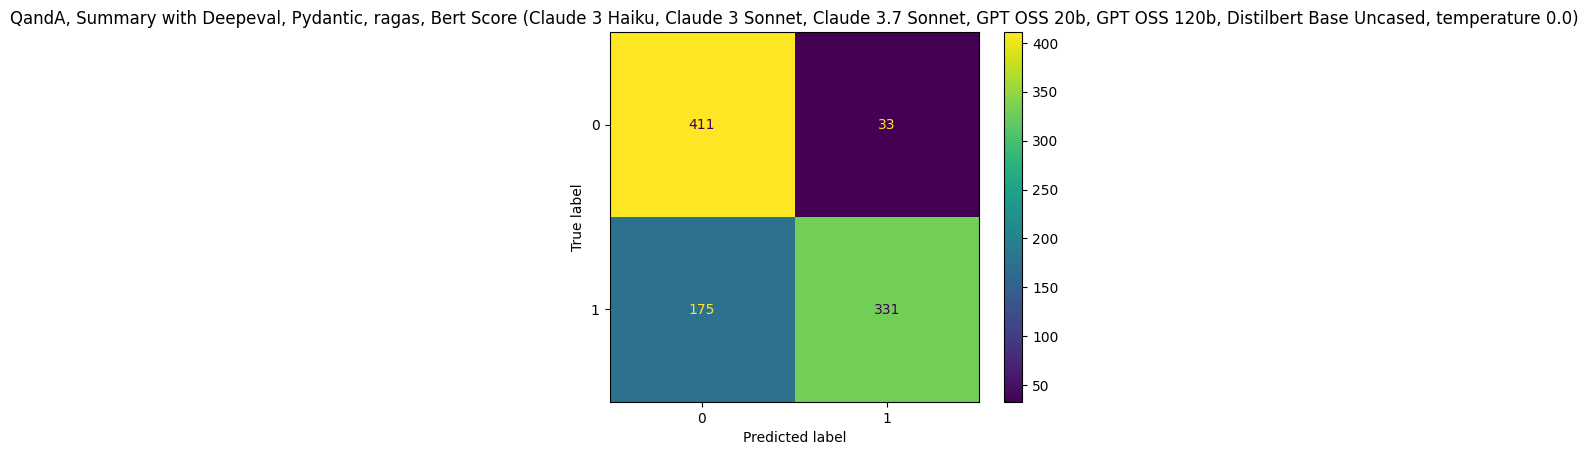

precision: 0.91, recall: 0.65, f1: 0.76

{'f1': 0.7609195402298851,
 'function': 'QandA, Summary',
 'method': 'Deepeval, Pydantic, ragas, Bert Score',
 'model_name': 'Claude 3 Haiku, Claude 3 Sonnet, Claude 3.7 Sonnet, GPT OSS '
               '20b, GPT OSS 120b, Distilbert Base Uncased',
 'precision': 0.9093406593406593,
 'recall': 0.6541501976284585,
 'score_correct': np.float64(0.7393386216384648),
 'score_diff': np.float64(0.5091728472268195),
 'score_incorrect': np.float64(0.23016577441164526),
 'score_mean': np.float64(0.5012609244374464),
 'score_median': np.float64(0.346302234009358),
 'temperature': '0.0'}


In [11]:
def get_results(df):
    results = {}

    results["function"] = f"{", ".join(df["function"].drop_duplicates().values)}"
    results["method"] = f"{", ".join(df["method"].drop_duplicates().values)}"
    results["model_name"] = f"{", ".join(df["model_name"].drop_duplicates().values)}"
    results["temperature"] = f"{str(df["temperature"].drop_duplicates().values[0])}"

    results["score_correct"] = df[df["is_correct"]]["score"].mean()
    results["score_incorrect"] = df[~df["is_correct"]]["score"].mean()
    results["score_diff"] = results["score_correct"] - results["score_incorrect"]
    results["score_mean"] = df["score_mean"].mean()
    results["score_median"] = df["score_median"].mean()
    #results["score_mean"] = (results["score_correct"] + results["score_incorrect"])/2
      
    results["precision"] = metrics.precision_score(df["is_correct"], df["passed"], zero_division=np.nan)
    results["recall"] = metrics.recall_score(df["is_correct"], df["passed"])
    results["f1"] = metrics.f1_score(df["is_correct"], df["passed"])
    confusion_matrix = metrics.confusion_matrix(df["is_correct"], df["passed"])
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    cm_display.plot()
    #plt.title(f"{results["method"]} ({results["model_name"]})")
    plt.title(f"{results["function"]} with {results["method"]} ({results["model_name"]}, temperature {results["temperature"]})")
    plt.show()
    print(f"precision: {results["precision"]:.2}, recall: {results["recall"]:.2}, f1: {results["f1"]:.2}\n")
    
    return results

results = get_results(evaluation_df)
pprint.pprint(results)

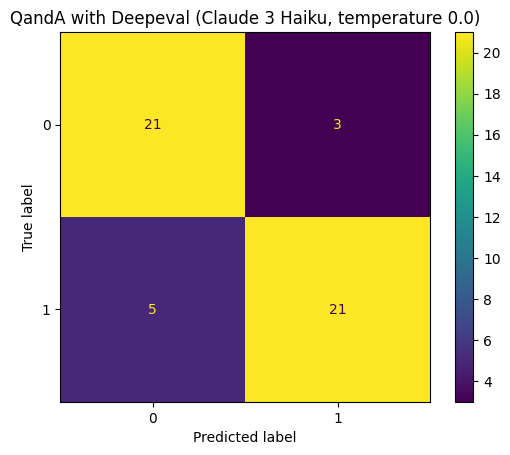

precision: 0.88, recall: 0.81, f1: 0.84



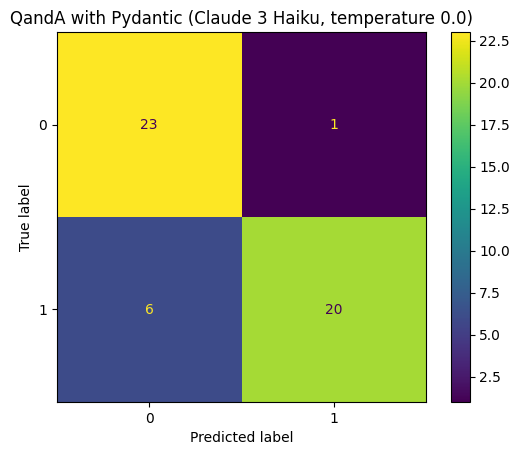

precision: 0.95, recall: 0.77, f1: 0.85



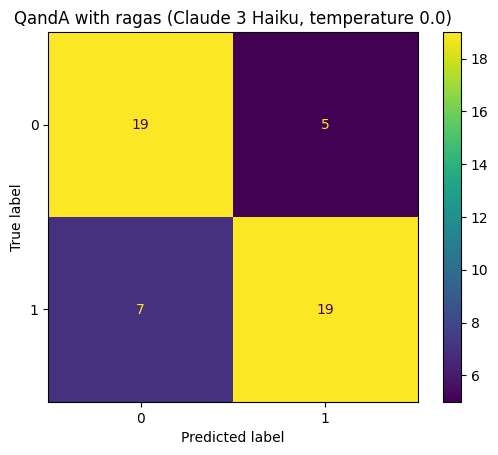

precision: 0.79, recall: 0.73, f1: 0.76



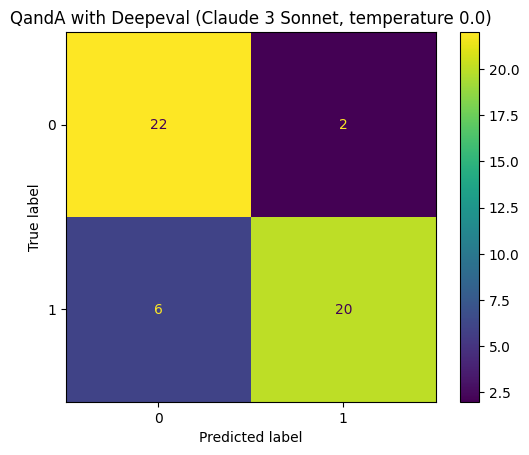

precision: 0.91, recall: 0.77, f1: 0.83



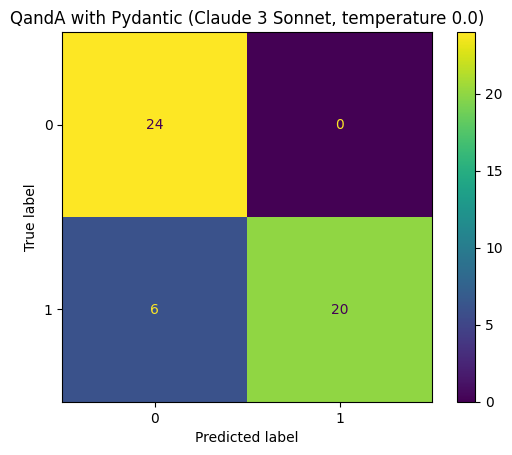

precision: 1.0, recall: 0.77, f1: 0.87



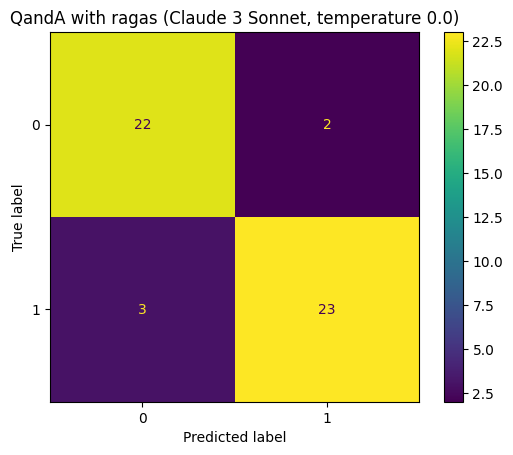

precision: 0.92, recall: 0.88, f1: 0.9



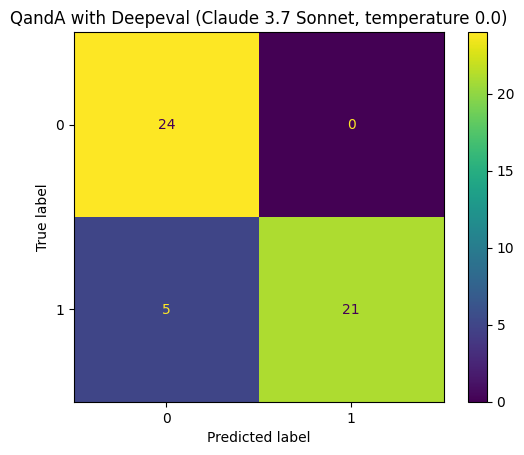

precision: 1.0, recall: 0.81, f1: 0.89



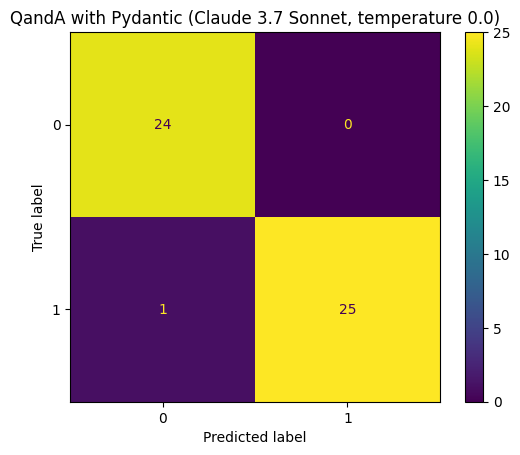

precision: 1.0, recall: 0.96, f1: 0.98



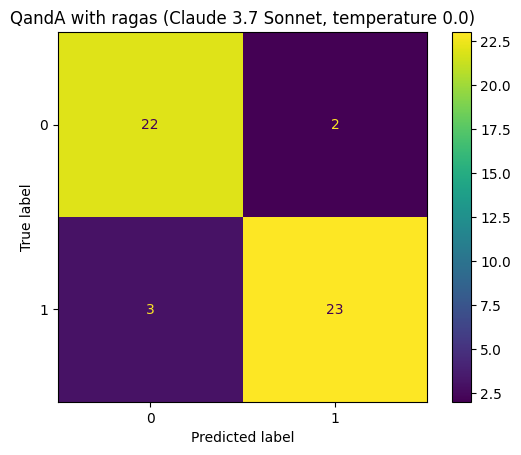

precision: 0.92, recall: 0.88, f1: 0.9



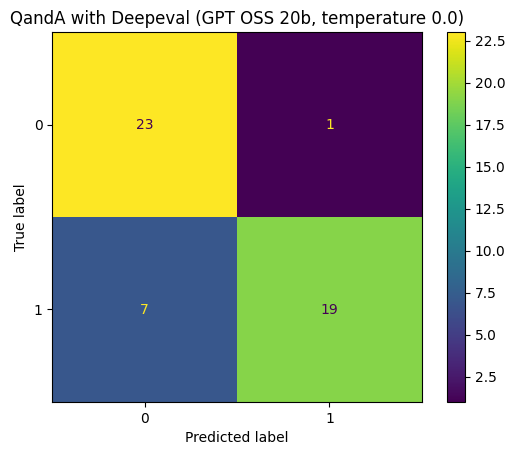

precision: 0.95, recall: 0.73, f1: 0.83



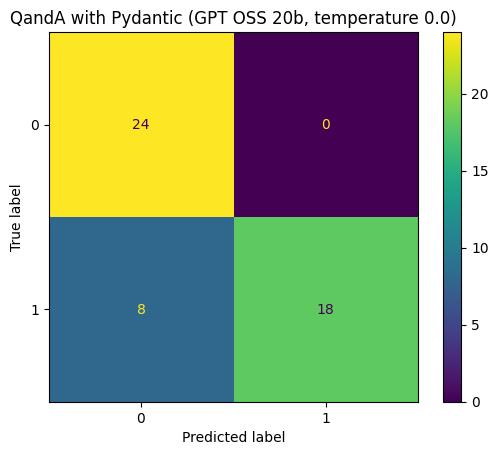

precision: 1.0, recall: 0.69, f1: 0.82



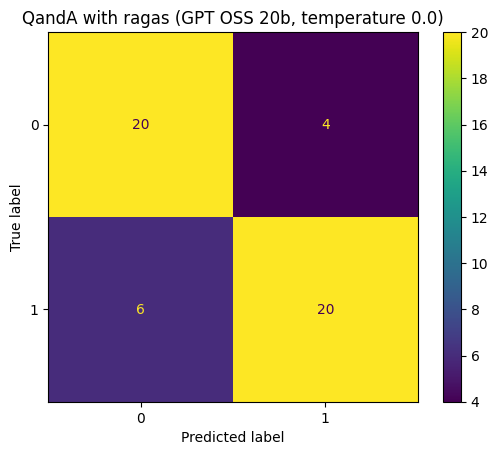

precision: 0.83, recall: 0.77, f1: 0.8



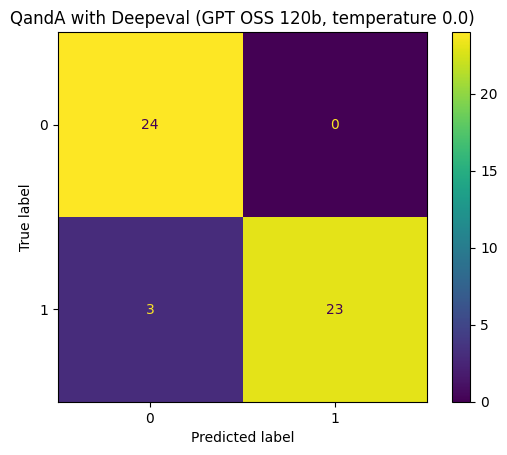

precision: 1.0, recall: 0.88, f1: 0.94



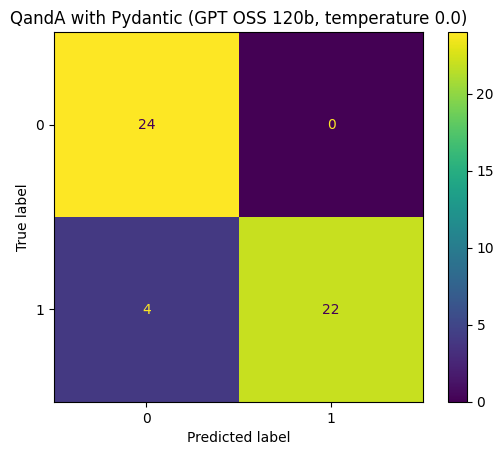

precision: 1.0, recall: 0.85, f1: 0.92



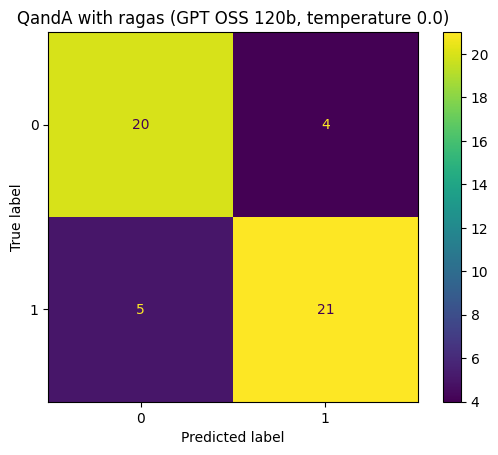

precision: 0.84, recall: 0.81, f1: 0.82



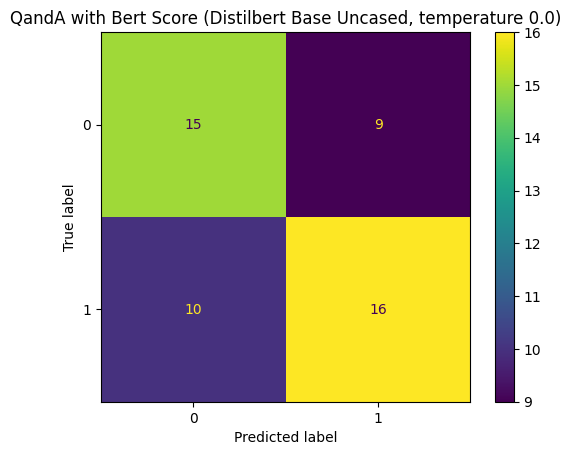

precision: 0.64, recall: 0.62, f1: 0.63



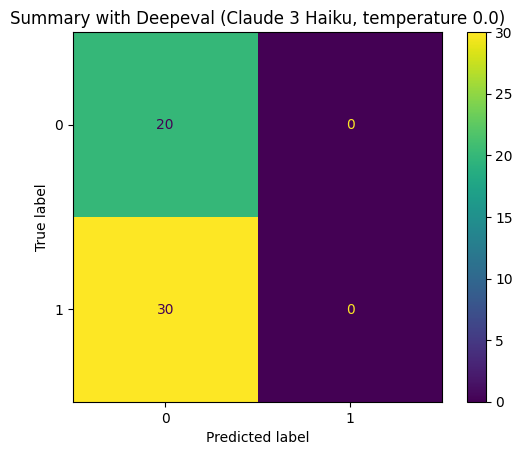

precision: nan, recall: 0.0, f1: 0.0



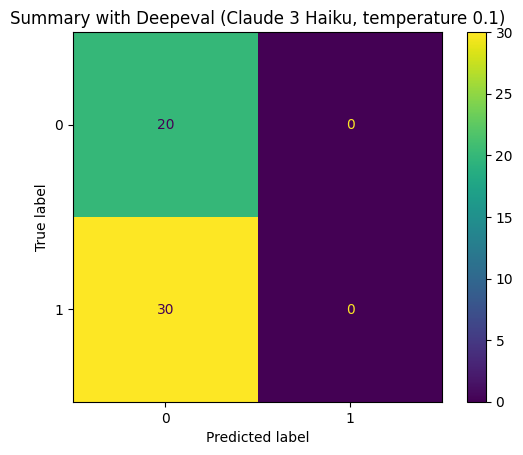

precision: nan, recall: 0.0, f1: 0.0



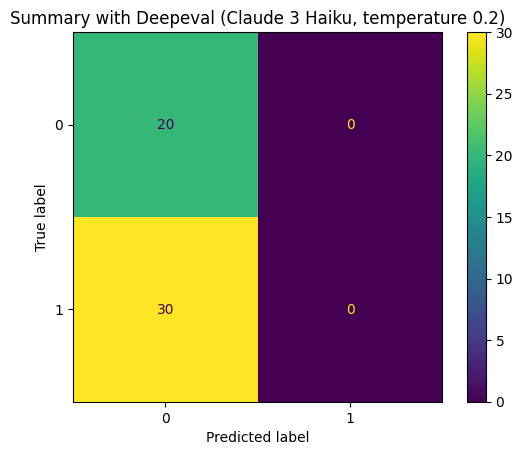

precision: nan, recall: 0.0, f1: 0.0



,function,method,model_name,temperature,score_correct,score_incorrect,score_diff,score_mean,score_median,precision,recall,f1
0,QandA,Deepeval,Claude 3 Haiku,0.0,0.796154,0.320833,0.475321,0.568000,0.500000,0.875000,0.807692,0.840000
1,QandA,Pydantic,Claude 3 Haiku,0.0,0.846154,0.145833,0.700321,0.510000,0.500000,0.952381,0.769231,0.851064
2,QandA,ragas,Claude 3 Haiku,0.0,0.699239,0.273160,0.426079,0.490548,0.547695,0.791667,0.730769,0.760000
3,QandA,Deepeval,Claude 3 Sonnet,0.0,0.750000,0.329167,0.420833,0.548000,0.400000,0.909091,0.769231,0.833333
4,QandA,Pydantic,Claude 3 Sonnet,0.0,0.682692,0.000000,0.682692,0.355000,0.000000,1.000000,0.769231,0.869565
5,QandA,ragas,Claude 3 Sonnet,0.0,0.733691,0.169230,0.564460,0.462750,0.344096,0.920000,0.884615,0.901961
6,QandA,Deepeval,Claude 3.7 Sonnet,0.0,0.773077,0.025000,0.748077,0.414000,0.300000,1.000000,0.807692,0.893617
7,QandA,Pydantic,Claude 3.7 Sonnet,0.0,0.908846,0.000000,0.908846,0.472600,0.150000,1.000000,0.961538,0.980392
8,QandA,ragas,Claude 3.7 Sonnet,0.0,0.719268,0.123397,0.595871,0.433250,0.210046,0.920000,0.884615,0.901961
9,QandA,Deepeval,GPT OSS 20b,0.0,0.492308,0.012500,0.479808,0.262000,0.000000,0.950000,0.730769,0.826087


In [12]:
results_methods = []
for row in evaluation_df[filter_columns].drop_duplicates().to_dict('records'):
    filter_df = evaluation_df.copy()
    for filter_column in filter_columns:
        filter_df = filter_df[filter_df[filter_column] == row[filter_column]]

    results = get_results(filter_df)
    results_methods.append(results)

results_df = pd.DataFrame(results_methods)
results_df.to_csv('output/results.csv', index=False)
results_df     

In [13]:
#index_columns = ["function", "method", "model_name", "temperature"]
#plot_df = results_df.set_index(index_columns)
#plot_df["score_diff"].plot(kind="bar", ylabel="score (correct) - score (incorrect)", title="difference in score vs method", color="cornflowerblue", edgecolor="black")

## Method

,function,model_name,temperature,score_correct,score_incorrect,score_diff,score_mean,score_median,precision,recall,f1
method,,,,,,,,,,,
Deepeval,QandA,Claude 3.7 Sonnet,0.0,0.773077,0.025000,0.748077,0.414000,0.300000,1.00,0.807692,0.893617
Pydantic,QandA,Claude 3.7 Sonnet,0.0,0.908846,0.000000,0.908846,0.472600,0.150000,1.00,0.961538,0.980392
ragas,QandA,Claude 3.7 Sonnet,0.0,0.719268,0.123397,0.595871,0.433250,0.210046,0.92,0.884615,0.901961
Bert Score,QandA,Distilbert Base Uncased,0.0,0.886584,0.803434,0.083150,0.846672,0.848689,0.64,0.615385,0.627451


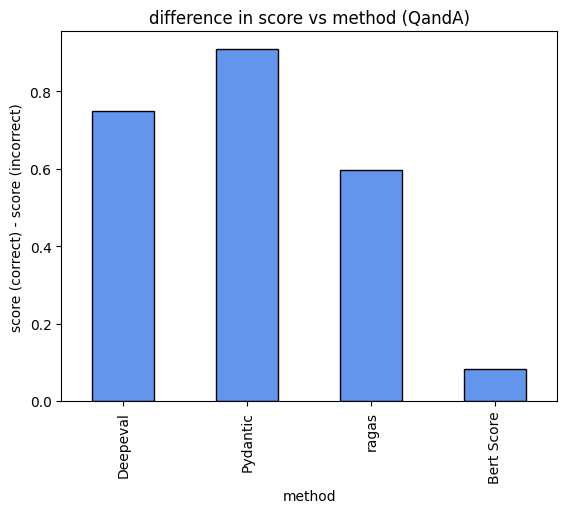

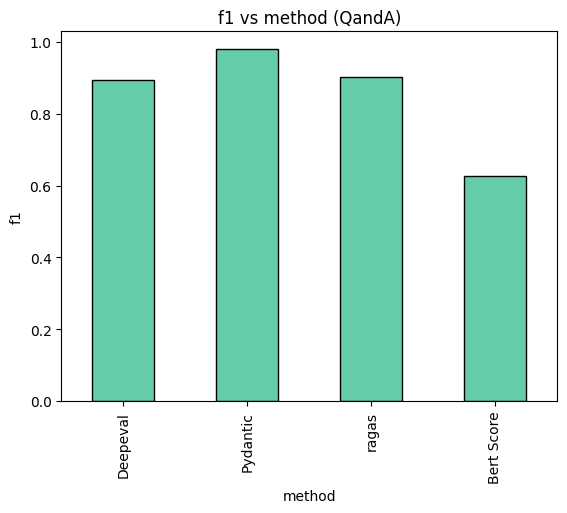

In [21]:
model_names=["Claude 3.7 Sonnet", "Distilbert Base Uncased"]
temperatures=[results_df["temperature"].drop_duplicates().to_list()[0], "None"]
functions = ["QandA", "Summary"]

for function in functions:
    plot_df = results_df[
        (results_df["function"] == function) &
        (results_df["temperature"].isin(temperatures)) &
        (results_df["model_name"].isin(model_names))
        ].set_index("method")
    
    if len(plot_df) > 0:
        display(plot_df)
        plot_df["score_diff"].plot(kind="bar", ylabel="score (correct) - score (incorrect)", title=f"difference in score vs method ({function})", color="cornflowerblue", edgecolor="black")
        plt.show()
        plot_df["f1"].plot(kind="bar", ylabel="f1", title=f"f1 vs method ({function})", color="mediumaquamarine", edgecolor="black")
        plt.show()

## Model

,function,method,temperature,score_correct,score_incorrect,score_diff,score_mean,score_median,precision,recall,f1
model_name,,,,,,,,,,,
Claude 3 Haiku,QandA,Pydantic,0.0,0.846154,0.145833,0.700321,0.5100,0.50,0.952381,0.769231,0.851064
Claude 3 Sonnet,QandA,Pydantic,0.0,0.682692,0.000000,0.682692,0.3550,0.00,1.000000,0.769231,0.869565
Claude 3.7 Sonnet,QandA,Pydantic,0.0,0.908846,0.000000,0.908846,0.4726,0.15,1.000000,0.961538,0.980392
GPT OSS 20b,QandA,Pydantic,0.0,0.692308,0.000000,0.692308,0.3600,0.00,1.000000,0.692308,0.818182
GPT OSS 120b,QandA,Pydantic,0.0,0.846154,0.000000,0.846154,0.4400,0.00,1.000000,0.846154,0.916667


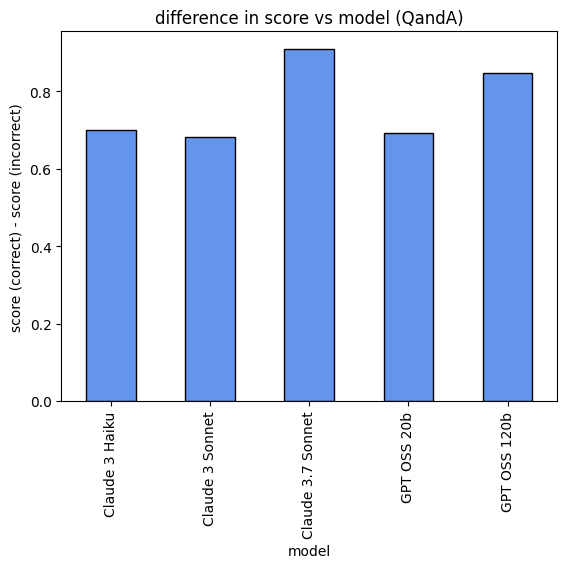

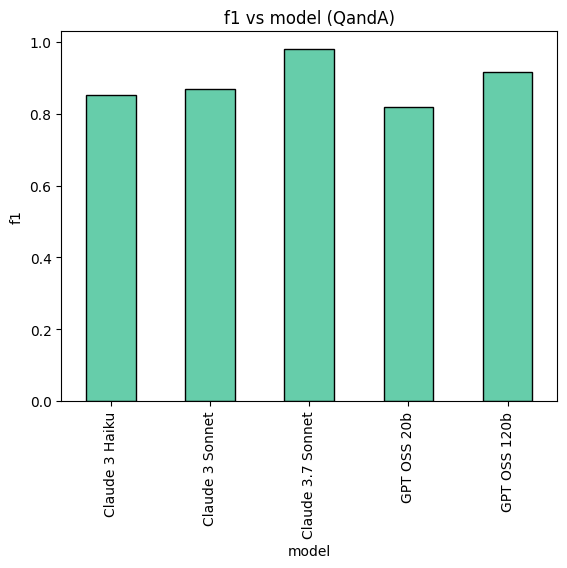

,function,method,temperature,score_correct,score_incorrect,score_diff,score_mean,score_median,precision,recall,f1
model_name,,,,,,,,,,,


In [22]:
method="Pydantic"

for function in functions:
    plot_df = results_df[
        (results_df["method"] == method) &
        (results_df["function"] == function) &
        (results_df["temperature"].isin(temperatures))
        ].set_index("model_name")
    display(plot_df)
    
    if len(plot_df) > 0:
        plot_df["score_diff"].plot(kind="bar", xlabel="model",  ylabel="score (correct) - score (incorrect)", title=f"difference in score vs model ({function})", color="cornflowerblue", edgecolor="black")
        plt.show()
        plot_df["f1"].plot(kind="bar", xlabel="model", ylabel="f1", title=f"f1 vs model ({function})", color="mediumaquamarine", edgecolor="black")
        plt.show()

## Temperature

,function,method,model_name,score_correct,score_incorrect,score_diff,score_mean,score_median,precision,recall,f1
temperature,,,,,,,,,,,
0.0,QandA,Pydantic,Claude 3.7 Sonnet,0.908846,0.0,0.908846,0.4726,0.15,1.0,0.961538,0.980392


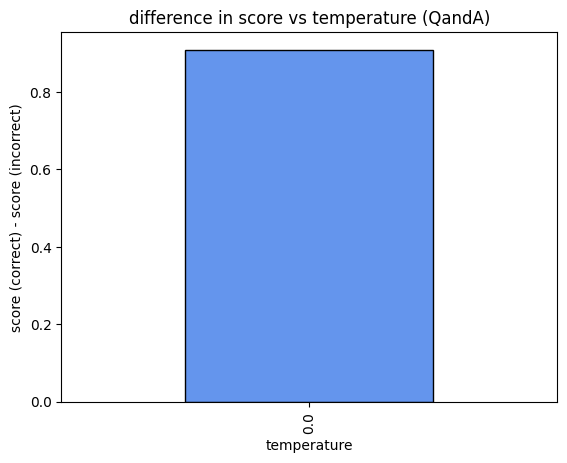

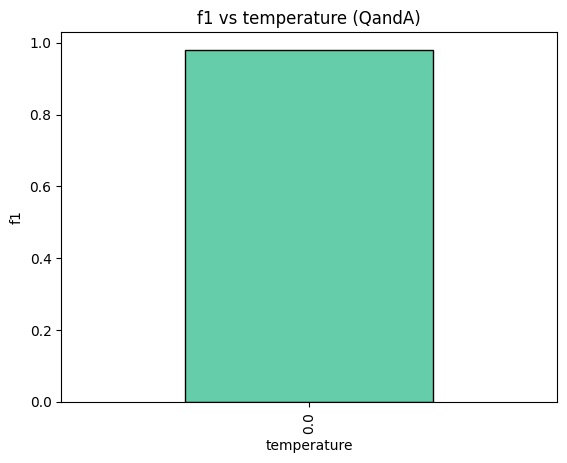

In [23]:
method="Pydantic"
model_name="Claude 3.7 Sonnet"

for function in functions:
    plot_df = results_df[
        (results_df["function"] == function) &
        (results_df["method"] == method) &
        (results_df["model_name"] == model_name)
        ].set_index("temperature")
    if len(plot_df) > 0:        
        display(plot_df) 
        plot_df["score_diff"].plot(kind="bar", ylabel="score (correct) - score (incorrect)", title=f"difference in score vs temperature ({function})", color="cornflowerblue", edgecolor="black")
        plt.show()
        plot_df["f1"].plot(kind="bar", ylabel="f1", title=f"f1 vs temperature ({function})", color="mediumaquamarine", edgecolor="black")
        plt.show()